# Rynek nieruchomości

### Celem jest zastosowanie uzyskanej wiedzy na praktycznym przykładzie.

Tym razem będziemy robić zadanie związane z rynkiem nieruchomości. Chcemy zbudować model, który orientuje się w cenach na rynku nieruchomości w Warszawie.

Podam Ci kilka przykładów, dlaczego to może być użyteczne biznesowo.

Na przykład startup - [open door](https://bit.ly/3d5zNwG) ma model, dzięki któremu może szybko oszacować koszt mieszkania w danym momencie posiadając tylko informację o lokalizacji oraz kupić je w kilka dni (tym samym osoba sprzedająca nie musi stresować się i czekać na kupca, gdyż ma gwarancję, że nieruchomość będzie kupiona).

Jeszcze kilka lat temu można było opowiadać o takich use  case tylko na przykładzie ze Stanów. W tak zwanym międzyczasie pojawiły się podobne projekty, także w Polsce np. taki o nazwie [SonarHome](https://bit.ly/3fYGq5N).


Przykłady z naszego podwórka, które szacują koszt uwzględniając kilka parametrów:
1. [Urban.one](https://bit.ly/3s7HNSh)
2. [Cenatorium](https://bit.ly/326V82t)

Co prawda warto zwrócić uwagę na różnice w naszych danych. W tym przypadku mamy ogłoszenia. Na przykład Urban.one posiadało prawdziwe informacje z transakcji. W praktyce oznacza to, że w ogłoszeniu zawsze mogę napisać np. 10 tys. więcej a może nawet i kilkaset, a faktycznie będzie ono sprzedane taniej (niestety tej informacji w ogłoszeniu nie ma).

**Uwaga!** To są prawdziwe dane, dlatego przypominam, że wykorzystujemy je tylko w celach **edukacyjnych**.

In [2]:
import pandas as pd
import numpy as np
np.random.seed(0)

import re
import sys

import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn.model_selection import KFold

import seaborn as sns

%matplotlib inline

In [3]:
def rmsle(actual, predicted):
    """
    Computes the root mean squared log error.
    """
    return np.sqrt(np.mean((np.power(np.log(np.array(actual)+1) - 
            np.log(np.array(predicted)+1), 2))))

# 1. Przygotowanie danych
Pamiętaj, że na początku zawsze mamy do czynienia z danymi, które są dość "surowe" i należy je przygotować. Akurat zrobiłem to za Ciebie :). Musisz tylko przyjrzeć się temu, jak wygląda proces (warto posiedzieć nad poniższym kodem trochę dłużej i w razie potrzeby rozłożyć każdą linijkę na czynniki pierwsze). Z drugiej strony możesz ten krok pominąć, jeśli uważasz, że to jest teraz zbyt skomplikowane i przejść do budowania modeli (punkt 2).

## Dlaczego warto wiedzieć, jak przygotować dane?
Podobne wyzwania spotkasz w praktyce. Jeśli chcesz być przygotowana/y na rzeczywistość, to zapraszam :).

In [5]:
train = pd.read_hdf('../input/train.realestate_row.h5')

In [ ]:
#train.info()

In [ ]:
#train.head()

Kilka funkcji pomocniczych, które pomogą wyciągnąć wartości z kolumn. Obecnie część kolumn wygląda jak słownik (klucz:wartość). Zadaniem jest wyciągnięcie każdego klucza (z tej jednej kolumny do osobnej). Dodatkowo w trakcie mapowania trzeba nałożyć odpowiedni filtr.

In [6]:
def get_value(items, key, type_value=np.int8, filter_=None):
    try:
        value = filter_(items[key]) if filter_ else items[key]
        return type_value(value)
    except:
        #print(items)
        return -1
    
def num_filter(val):
    return re.sub('[^0-9]','', val)

def float_filter(val):
    return re.sub('[^0-9\,\.]','', val).replace(',', '.')

def str_filter(val):
    return val.lower().strip()

## Ogłoszenie
Składa się z kilku sekcji:
- budynek (informacja o budynku)
- mieszkanie
- dodatkowy opis
- okolica
- zalety 
- ...

Każda sekcja zawiera różne informacje (także w różnym formacie). Dlatego w "surowej" wersji danych `train_row.h5` w jednej kolumnie znajduje się słownik lub lista, z której trzeba wyciągnąć informacje i rozbić je na osobne kolumny.

## Budynek
Wyciągamy 4 zmienne:
* Liczba pięter
* Typ budynku
* Rok budowy
* Materiał

In [7]:
train['building_num_floor'] = train['building'].map(lambda x: get_value(x, 'Liczba pięter', np.int8, num_filter))
train['type_building'] = train['building'].map(lambda x: get_value(x, 'Typ budynku', str, str_filter ))
train['year_building'] = train['building'].map(lambda x: get_value(x, 'Rok budowy', np.int16, num_filter ))
train['material_building'] = train['building'].map(lambda x: get_value(x, 'Materiał', str, str_filter ))

## Dodatkowe zalety
Najpierw tworzymy `set` o nazwie `all_benefits`. `Set` ma taką własność, że trzyma tylko unikalne wartości. Chcemy sprawdzić wszystkie możliwe zalety iterując po kolumnie `extra_benefits` i wrzucając do `all_benefits`.

Przy okazji też normalizujemy zalety (robiąc wszystko z małej litery i usuwając spacje na początku i końcu).

In [8]:
all_benefits = set()

def extract_benefits(benefit):
    if 'nan' == str(benefit): return
    
    for value in benefit.split(','):
        value = value.lower().strip()
        if '' == value: continue
            
        all_benefits.add(value)
    
_ = train['extra_benefits'].map(extract_benefits)

all_benefits

{'antresola',
 'centralne ogrzewanie',
 'domofon',
 'internet',
 'loft',
 'ochrona',
 'ogrzewanie elektryczne',
 'ogrzewanie miejskie',
 'ogrzewanie podłogowe',
 'patio',
 'podjazd dla niepełnosprawnych',
 'recepcja',
 'telefon',
 'teren ogrodzony',
 'tv kablowa',
 'wideofon',
 'winda'}

Mając wszystkie możliwe (dla naszego zbioru) zalety, tworzymy osobną kolumnę dla każdej z nich. Jeśli ta zaleta występuje dla danego mieszkania - to kolumna będzie miała wartość 1, w innym przypadku będzie to 0.

In [9]:
idx_benefits, labels_benefits = pd.factorize( list(all_benefits) )

for idx_benefit in idx_benefits:
    cat_name = 'benefit_{0}'.format( labels_benefits[idx_benefit].replace(' ', '_') )
    ben_label = labels_benefits[idx_benefit]
    
    train[cat_name] = train['extra_benefits'].map(lambda x: int(ben_label in x.lower()) if 'nan' != str(x) else 0 )

## Koszt 
Zwrócę uwagę, że na stronie miejsca dziesiętne dla liczb podane są za przecinkiem. Natomiast, żeby zrzutować to do `float`, trzeba mieć kropkę, dlatego została użyta funkcja `.replace(',', '.')`.

Dla przykładu poniżej można zobaczyć, że rzutowanie "1,2" skończy się wyjątkiem: `ValueError: could not convert string to float: '1,2'`.

In [10]:
print( float('1.2'))
print( float('1,2'))

1.2


ValueError: could not convert string to float: '1,2'

Używając `split` możemy wyciągnąć całkowity koszt. Docelowo wyglądało to tak: **458 094 zł (7 800 zł/m2 )**, a przy pomocy `split` dzielimy string na dwie części: przed 'zł' i po. W naszym przypadku jest potrzebna pierwsza część (bo tam jest zawarty koszt), więc funkcja wyciągająca koszt będzie wyglądać tak: `.split('zł')[0]`. 

Przykład:

In [11]:
'458 094 zł (7 800 zł/m '.split('zł') #zwraca listę, pierwszy element zawiera koszt całkowity

['458 094 ', ' (7 800 ', '/m ']

Pobieramy pierwszy element, dodatkowo usuwamy spacje, a następnie rzutujemy do `float`.

In [12]:
'458 094 zł (7 800 zł/m '.split('zł')[0].replace(' ', '')

'458094'

Teraz ten kod dodajemy do funkcji `get_price`. Dodatkowo dodajemy blok `try/except` na wypadek jakby coś poszło nie tak. Na przykład czasem zamiast ceny jest wartość "Zapytaj o cenę", w tej sytuacji zwracamy: -1.

In [13]:
def get_price(value):
    try:
        if 'nan' == str(value): return np.nan        
        return float(value.split('zł')[0].replace(' ', '').replace(',', '.'))
    except:
        #print(value)
        return -1
    
train['price'] = train.offer.map(get_price)

train.head()

,building,extra_benefits,parking,apartament,offer,surroundings,extra_description,benefit_investment,broker_license,stats,...,benefit_podjazd_dla_niepełnosprawnych,benefit_centralne_ogrzewanie,benefit_antresola,benefit_recepcja,benefit_internet,benefit_patio,benefit_wideofon,benefit_domofon,benefit_teren_ogrodzony,price
0,"{'Typ budynku': 'apartamentowiec', 'Liczba pię...",NaN,garaż,"{'Łazienka': 'w aneksie', 'Liczba pokoi': 'par...",699 000 zł (4 288 zł/m,{'Zdrowie': [' ...,[OSTATNIE WOLNE LOKALE !!!!!!!!!! OSIED...,NaN,,"[[Źródło: , Osoba prywatna], [Rynek: , wtórny]...",...,0,0,0,0,0,0,0,0,0,699000.0
0,"{'Typ budynku': 'apartamentowiec', 'Liczba pię...",NaN,NaN,"{'Liczba pokoi': '8', 'Kuchnia': 'bardzo dobry...",560 000 zł (8 917 zł/m,{'Zdrowie': [' ...,[Mieszkanie typu studio na warszawskiej Ochoci...,NaN,,"[[Źródło: , Biuro nieruchomości], [Rynek: , wt...",...,0,0,0,0,0,0,0,0,0,560000.0
0,"{'Typ budynku': 'blok', 'Liczba pięter': '4', ...","centralne ogrzewanie, domofon, teren ogrodzony",NaN,"{'Łazienka': 'z oknem, oddzielna', 'Liczba pok...",309 000 zł (6 119 zł/m,{'Zdrowie': [' ...,"[Oferujemy mieszkanie na 3 piętrze, dwustronne...",NaN,,"[[Źródło: , Osoba prywatna], [Rynek: , wtórny]...",...,0,1,0,0,0,0,0,1,1,309000.0
0,"{'Typ budynku': 'blok', 'Liczba pięter': '4', ...",NaN,NaN,"{'Liczba pokoi': 'parter', 'Kuchnia': 'do remo...",270 000 zł (7 297 zł/m,{},"[Witam, oferuję Państwu mieszkanie na spokojny...",NaN,Nr licencji pośrednika: 11710,"[[Źródło: , Biuro nieruchomości], [Rynek: , wt...",...,0,0,0,0,0,0,0,0,0,270000.0
0,"{'Typ budynku': 'blok', 'Liczba pięter': '3', ...",NaN,NaN,"{'Liczba pokoi': '3', 'Kuchnia': '3', 'Forma w...",500 000 zł (7 042 zł/m,{'Zdrowie': [' ...,[Jeśli chcesz mieszkać w doskonale skomunikowa...,NaN,,"[[Źródło: , Biuro nieruchomości], [Rynek: , wt...",...,0,0,0,0,0,0,0,0,0,500000.0


## Mieszkanie

Cechy mieszkania. 

Ciekawostka w tym przypadku jest taka, że podczas zbierania danych pojawił się bug (jak to często w życiu bywa). Wyglądało to tak, że w cesze powierzchni mieszkania była podana liczba i m2. Ta dwójka po "m" wyglądała jak kolejna liczba (cecha), w wyniku czego wszystkie cechy przesunęły się o jeden. 

#### Miało być:
- powierzchnia: 100m2
- cecha1: A
- cecha2: B
- cecha3: C

#### Jest:
- powierzchnia: 100m
- cecha1: 2
- cecha2: A
- cecha3: B

Dlatego pierwszym krokiem jest naprawienie wartości w cechach (nie musisz rozumieć całego kodu), a następnie wyciągnięcie ich do osobnych kolumn.

In [14]:
orders = {
    'Forma własności': 1,
    'Powierzchnia': 2,
    'Piętro': 3,
    'Liczba pokoi': 4,
    'Liczba poziomów': 5,
    'Wykończenie': 6,
    'Stan mieszkania': 7,
    'Głośność': 8,
    'Kuchnia': 9,
    'Łazienka': 10,
    'Stan łazienki': 11,
    'Stan instalacji': 12,
    'Okna': 13,
    'Usytuowanie wzgl. stron świata': 14,
    'Powierzchnia dodatkowa': 15
}

def get_map_attrs(apartament):
    sorted_attrs = sorted([ (key, orders[key]) for key in apartament.keys()], key=lambda key: key[1])

    map_attrs = {}
    for idx, attr in enumerate(sorted_attrs):
        if attr[0] == 'Forma własności' or attr[0] == 'Powierzchnia': 
            map_attrs[attr[0]] = sorted_attrs[idx][0]
            continue

        if idx + 1 < len(sorted_attrs):
            map_attrs[attr[0]] = sorted_attrs[idx+1][0]
            
    return map_attrs
            
def do_apartament_fix(apartament):
    if 'nan' == str(apartament): return np.nan
    
    map_attrs = get_map_attrs(apartament)
    apartment_fix = {}
    for key in apartament:
        if key not in map_attrs: continue
        apartment_fix[key] = apartament[map_attrs[key]]
            
    return apartment_fix

train['apartament_fix'] = train['apartament'].map(do_apartament_fix)

Teraz zmienna `apartament_fix` posiada naprawione wartości. Wyciągamy cechy mieszkań do osobnych kolumn.

In [15]:
train['apartament_ownership'] = train['apartament_fix'].map(lambda x: get_value(x, 'Forma własności', str, str_filter))
train['apartament_area'] = train['apartament_fix'].map(lambda x: get_value(x, 'Powierzchnia', float, float_filter))
train['apartament_floor'] = train['apartament_fix'].map(lambda x: get_value(x, 'Piętro', str, str_filter))
train['apartament_num_rooms'] = train['apartament_fix'].map(lambda x: get_value(x, 'Liczba pokoi', np.int8, num_filter))

train['apartament_num_levels'] = train['apartament_fix'].map(lambda x: get_value(x, 'Liczba poziomów', str, str_filter))
train['apartament_finished'] = train['apartament_fix'].map(lambda x: get_value(x, 'Wykończenie', str, str_filter))
train['apartament_condition'] = train['apartament_fix'].map(lambda x: get_value(x, 'Stan mieszkania', str, str_filter))
train['apartament_noise'] = train['apartament_fix'].map(lambda x: get_value(x, 'Głośność', str, str_filter))
train['apartament_kitchen'] = train['apartament_fix'].map(lambda x: get_value(x, 'Kuchnia', str, str_filter))
train['apartament_bathroom'] = train['apartament_fix'].map(lambda x: get_value(x, 'Łazienka', str, str_filter))
train['apartament_bahtroom_condition'] = train['apartament_fix'].map(lambda x: get_value(x, 'Stan łazienki', str, str_filter))
train['apartament_installation_condition'] = train['apartament_fix'].map(lambda x: get_value(x, 'Stan instalacji', str, str_filter))
train['apartament_window'] = train['apartament_fix'].map(lambda x: get_value(x, 'Okna', str, str_filter))
train['apartament_appartament'] = train['apartament_fix'].map(lambda x: get_value(x, 'Usytuowanie wzgl. stron świata', str, str_filter))

## Okolica
Ze zmiennej `surroundings` mamy informacje o obiektach, które znajdują się obok. Możesz wyciągnąć te wartości i zrobić z nimi coś wartościowego ;)

Jest tego sporo. Na podstawie tej zmiennej można wygenerować dużo kolejnych cech, jeśli chcesz poeksperymentować.

In [16]:
train.head(1).surroundings[0]['Edukacja']

['\n                                              ',
 'Gimnazjum nr 5 Zespołu Szkół Prywatnych Free',
 ' - 1,7\xa0km',
 '\n                                              ',
 'Integracyjne Językowe Przedszkole Montessori,Klub Malucha i Żłobek',
 ' - 1,8\xa0km',
 '\n                                          ']

## Opis dodatkowy

W zmiennej `extra_description` jest dodatkowy opis. Gdy jest bardzo dużo tekstu, to też można wyciągnąć wiele ciekawych cech.

In [17]:
print(train.head(1).extra_description[0])

['OSTATNIE WOLNE LOKALE !!!!!!!!!!        OSIEDLE ODDANE DO UŻYTKOWANIA', '\n', '\nRezydencje TAMTARADEI to nowoczesny i elegancki kompleks mieszkalny utrzymany w duchu przyjaznego modernizmu, dedykowany rodzinom.', '\n', '\n W skład Rezydencji TAMTARADEI wchodzi pięć budynków cztero-lokalowych o jednolitej wysokości trójkondygnacyjnej.', '\n', '\n Każdy lokal rezydencji posiada powierzchnię całkowitą 193 m2, w tym użytkową 163 m2. Parter to część dzienna rezydencji z przestronnym i niezwykle jasnym salonem (35 m2) z kuchnią w aneksie (8m2) z przyległym pomieszczeniem gospodarczym oraz wc. W poziomie parteru zawarty jest również garaż (16m2).', '\n I piętro natomiast to część nocna zawierająca 3 sypialnie oraz 2 łazienki (jedna z nich z bezpośrednim wejściem z sypialni, do której przynależy również taras).', '\n Na II piętrze rezydencji znajduje się otwarta przestrzeń typu studio oraz łazienka. Niewątpliwym atutem ostatniej kondygnacji są 2 tarasy, w tym jeden o powierzchni 24 m2 !', '

## Zalety inwestycji
Trochę powiela się to z innymi polami (np. z dodatkowym opisem), ale w tym przypadku są używane tak zwane "słowa klucze".

In [18]:
all_benefits_investment = set()

def extract_benefits_investment(benefit):
    if 'nan' == str(benefit): return
    
    for value in benefit.split(','):
        value = value.lower().strip()
        if '' == value: continue
            
        all_benefits_investment.add(value)
    
_ = train['benefit_investment'].map(extract_benefits_investment)

all_benefits_investment

{'antresola',
 'centralne ogrzewanie',
 'domofon',
 'internet',
 'loft',
 'ochrona',
 'ogrzewanie miejskie',
 'ogrzewanie podłogowe',
 'patio',
 'podjazd dla niepełnosprawnych',
 'recepcja',
 'telefon',
 'teren ogrodzony',
 'tv kablowa',
 'wideofon',
 'winda'}

Jak widać pokrywa się to z już wcześniej przerobionymi zaletami...
```
{'antresola',
 'centralne ogrzewanie',
 'domofon',
 'internet',
 'loft',
 'ochrona',
 'ogrzewanie elektryczne',
 'ogrzewanie miejskie',
 'ogrzewanie podłogowe',
 'patio',
 'podjazd dla niepełnosprawnych',
 'recepcja',
 'telefon',
 'teren ogrodzony',
 'tv kablowa',
 'wideofon',
 'winda'}
 ```
 
Może się okazać, że ktoś w ogłoszeniu wpisuje to do pola "Dodatkowe zalety", a ktoś inny do "Zalety inwestycji". Natomiast na tym etapie zostawię to jako dodatkowe zadanie, do którego będzie można wrócić.

## Informacje statystyczne

In [19]:
list(train.stats.head(1))

[[['Źródło: ', 'Osoba prywatna'],
  ['Rynek: ', 'wtórny'],
  ['Dodano: ', 'więcej niż miesiąc temu'],
  ['Aktualizacja: ', 'dzisiaj'],
  ['Liczba odsłon: ', '2596']]]

Ta informacja jest aktualna w momencie pobrania tego ogłoszenia. To oznacza, że dzisiaj jest dniem, kiedy dane były zbierane. Dlatego trzeba ostrożnie tym manipulować.

Informacja o liczbie odsłon może być ciekawym kryterium atrakcyjności. Skoro ludzie sprawdzają ogłoszenie częściej, to coś w nim może być.

In [20]:
train['stats_who'] = train.stats.map(lambda x: str(x[0][1].lower().strip()) if x else 'unknown')
train['stats_market'] = train.stats.map(lambda x: x[1][1].lower().strip() if x else 'unknown')
train['stats_created_at'] = train.stats.map(lambda x: x[2][1].lower().strip() if x else 'unknown')
train['stats_updated_at'] = train.stats.map(lambda x: x[3][1].lower().strip() if x else 'unknown')
train['stats_viewers'] = train.stats.map(lambda x: int(x[4][1].lower().strip()) if x and len(x) == 5 else -1)

Dla przykładu pokażę, jak można to zwizualizować.

biuro nieruchomości    16449
deweloper               2387
unknown                  268
osoba prywatna            28
instytucja                12
Name: stats_who, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)
Index(['osoba prywatna', 'biuro nieruchomości', 'deweloper', 'unknown',
       'instytucja'],
      dtype='object')


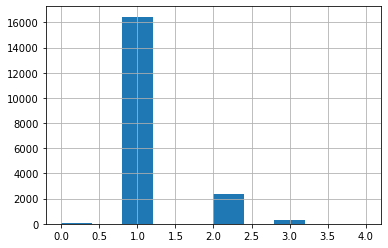

In [21]:
print(train['stats_who'].value_counts())
train['stats_who_cat'], labels = pd.factorize(train['stats_who'])
print( train['stats_who_cat'].hist() )
print(labels)

Najbardziej popularna jest druga grupa (wartość 1, bo zaczynamy od 0) i są to biura nieruchomości.

### stats_viewers
Wartości są za bardzo zmienne żeby zobaczyć histogram, ale można je rozbić na grupy.

In [22]:
pd.qcut(train[ train.stats_viewers != -1 ]['stats_viewers'], 5).unique()

[(319.0, 90536.0], (189.0, 319.0], (119.0, 189.0], (3.999, 75.0], (75.0, 119.0]]
Categories (5, interval[float64, right]): [(3.999, 75.0] < (75.0, 119.0] < (119.0, 189.0] < (189.0, 319.0] < (319.0, 90536.0]]

In [23]:
train.head(1)

,building,extra_benefits,parking,apartament,offer,surroundings,extra_description,benefit_investment,broker_license,stats,...,apartament_bahtroom_condition,apartament_installation_condition,apartament_window,apartament_appartament,stats_who,stats_market,stats_created_at,stats_updated_at,stats_viewers,stats_who_cat
0,"{'Typ budynku': 'apartamentowiec', 'Liczba pię...",NaN,garaż,"{'Łazienka': 'w aneksie', 'Liczba pokoi': 'par...",699 000 zł (4 288 zł/m,{'Zdrowie': [' ...,[OSTATNIE WOLNE LOKALE !!!!!!!!!! OSIED...,NaN,,"[[Źródło: , Osoba prywatna], [Rynek: , wtórny]...",...,-1,nowa,nowe plastikowe,"północno-zachodnie, południowo-wschodnie",osoba prywatna,wtórny,więcej niż miesiąc temu,dzisiaj,2596,0


Usuńmy cechy, które już są zbędne (już wyciągnęliśmy z tych kolumn dane, więc nie będziemy ich używać):
- `building`
- `extra_benefits`
- `apartament`
- `offer`
- `stats`

In [24]:
if 'building' in train: del train['building']
if 'extra_benefits' in train: del train['extra_benefits']
if 'apartament' in train: del train['apartament']
if 'offer' in train: del train['offer']
if 'stats' in train: del train['stats']

Zapiszmy nowy (oczyszczony) zbiór danych do `.h5`.

**Uwaga!** Domyślnie kod zapisu jest zakomentowany - uważaj, żeby nie nadpisać danych.

In [25]:
#train.to_hdf('my_train.realestate.h5', 'data') #zapisze w katalogu `/notebooks`

# 2. Zrozumienie danych i biznesu

Jeśli chodzi o biznes, podrzucę Ci kilka inspiracji, ale zdecyduj samodzielnie:
1. Można robić predykcję kosztu, żeby znajdować tańsze (lub droższe) mieszkania. Liczba ogłoszeń zwykle jest znacznie większa niż ilość wolnego czasu, który ma potencjalny klient. Nasz model może być mądrym filtrem, który znajduje ciekawe (np. tańsze) mieszkania dla klientów.

2. Możesz zbudować model (silnik), któremu można podać, że "chcę mieszkanie, które ma tyle i tyle metrów, na takim piętrze, w takiej okolicy" i model "podpowie", ile to będzie kosztować.

3. Agenci nieruchomości nadal mają problemy z przygotowaniem ogłoszeń, więc można spróbować znaleźć zależności - jak wyglądają ogłoszenia prezentujące mieszkania kosztujące więcej niż powinny, a mimo to atrakcyjne (mają sporo wejść).

4. Można przygotować asystenta, który oczekuje na pewne wskazówki (wymagania), następnie podpowiada, że jeśli kupisz mieszkanie piętro niżej lub bez garażu to zaoszczędzisz 20% lub w drugą stronę - dopłać jedynie 1% i już masz garaż oraz balkon :)

Jak widać pomysłów na wykorzystanie danych jest naprawdę wiele.

Teraz spróbujmy zrozumieć nasze dane.

In [ ]:
# train = pd.read_hdf('../input/train.realestate.h5')

## Zmienna docelowa

To którą zmienną wybierzesz w dużej mierze zależy od biznesu, ale raczej to wszystko będzie odwoływać się w tym wypadku do zmiennej `price`. Chcemy zbudować model, które potrafi dość dokładnie oszacować koszt na podstawie cech.

Dlatego zbadajmy je dokładnie.

In [28]:
print (train[ train.price.isnull() ].shape)
print (train[ train.price == -1 ].shape)

(268, 50)
(1748, 50)


Ok, mamy **268 wierszy**, gdzie price nie jest znany (**nan**) i **1748 wierszy** gdzie jest **-1**, czyli były jakieś trudności (np. cena nie była podana). 

### Co zrobimy? 
Usuwamy i idziemy dalej :).

In [29]:
train = train[ False == train.price.isnull() ]
#równoznacznie, zamiast "False =="  możemy użyć tyldę "~"
#train = train[ ~train.price.isnull() ]

train = train[ train.price != -1 ]

train.shape

(17128, 50)

Mamy **17 128** obiektów, które mają cechę `price`.

Od razu podpowiem, że opłaca się zrobić transformację logarytmiczną. Dlaczego? Zrób wykres poniżej i spróbuj odpowiedzieć dlaczego :).

Poniżej będą 4 pary wykresów:
1. Histogram na `price`
2. Obcinamy zbyt długi ogon z prawej strony (1% ekstremalnie drogich nieruchomości)
3. Transformacja logarytmiczna `price`
4. Obcinamy po jednym procencie z lewej i prawej strony (czyli zostawiamy 98% danych), żeby zobaczyć, jak zmienił się rozkład danych (z punktu widzenia symetrii).

<Figure size 36000x1440 with 0 Axes>

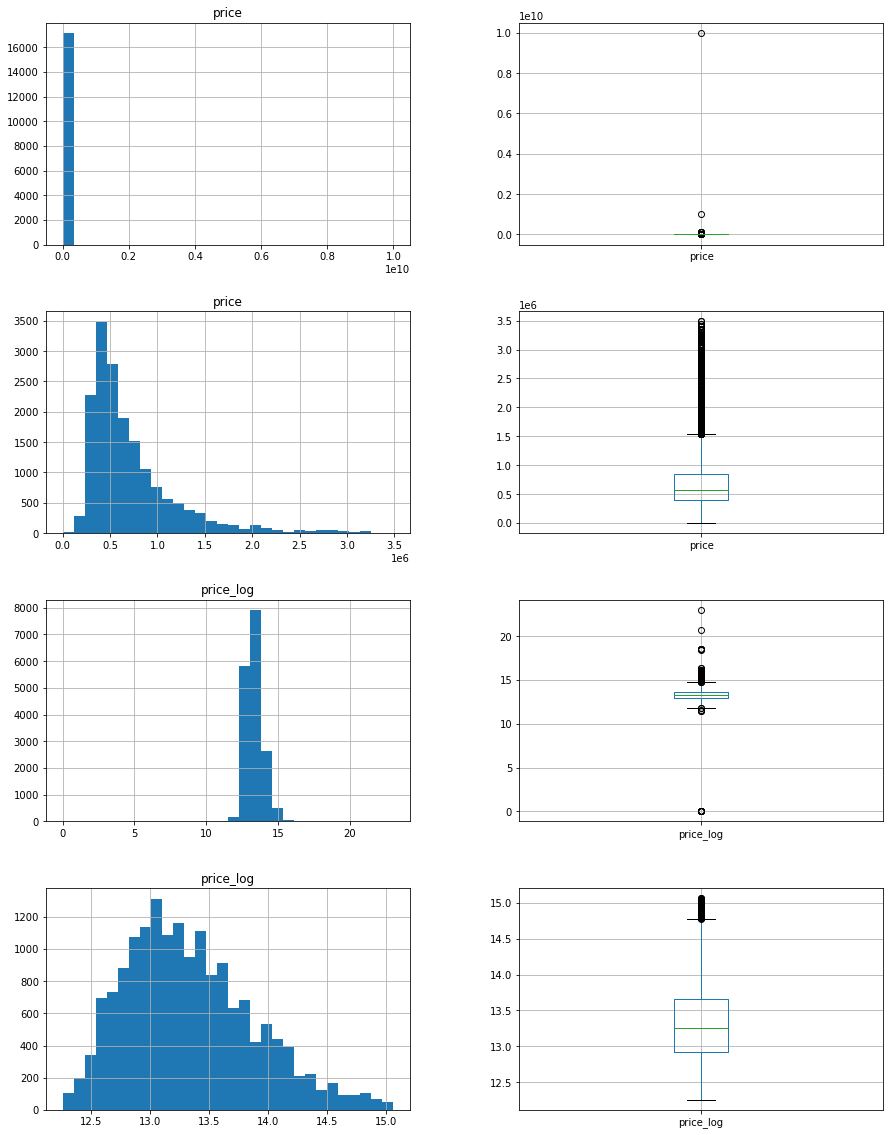

In [30]:
train['price_log'] = np.log( train['price'] )

plt.figure(figsize=(500,20))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(15, 20))
fig.subplots_adjust(hspace=.8)

def sub_plot(data, column, ax1, ax2):
    data.hist(column, bins=30, ax=ax1)
    data.boxplot(column, ax=ax2)

sub_plot(train, 'price', ax1, ax2)
sub_plot(train[ train.price < np.percentile( train.price, 99 ) ], 'price', ax3, ax4)
sub_plot(train, 'price_log', ax5, ax6)
sub_plot(train[ (train.price_log > np.percentile( train.price_log, 1 )) & (train.price_log < np.percentile( train.price_log, 99 )) ], 'price_log', ax7, ax8)

Czy już domyślasz się, dlaczego zrobiliśmy transformację?

Rozkład stał się bardziej [symetryczny](https://bit.ly/3mNXoWd). Czasem mówi się tak: skoro używamy drzew decyzyjnych itp., nie powinno mieć to wpływu. 

Natomiast w praktyce ma :) W sumie jeszcze zobaczymy to na przykładzie.

Żeby już od razu zacząć działać, spróbujmy zbudować pierwszy model. Jako metrykę sukcesu, możemy wziąć: **RMSLE**. 

#### Dlaczego? 
Chociażby dlatego, że trzeba coś wybrać, akurat ta metryka jest mniej podatna na wartości odstające (*outliers*). W naszym przypadku zależy nam na tym, żeby ogólnie robić dobrą predykcję, a nie tylko dla najdroższych nieruchomości (bo normalnie, tam będzie największa różnica ilościowa). Chociaż w tym przypadku również można zastosować **MAE**.

## Basic Model

In [31]:
X = train[ ['year_building'] ].values
y = train['price'].values

model = DummyRegressor()

cv = KFold(n_splits=4)

scores = []
for train_idx, test_idx in cv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    score = rmsle(y_test, y_pred)
    scores.append( score )
    
    
print(np.mean(scores), np.std(scores))

1.068303572845021 0.24185272714742417


Świetnie! Już mamy wynik: **1.068**. Teraz kod, który był powyżej, należy wrzucić do funkcji, żeby móc łatwiej testować w przyszłości (z innymi modelami, innymi cechami itd).

In [32]:
def get_feats(df):
    feats = df.select_dtypes(include=[int, float]).columns 
    return feats[ (feats != 'price') & (feats != 'price_log') ].values

def get_X(df):
    return df[ get_feats(df) ].values

def get_y(df, target_var='price'):
    return df[target_var].values

def get_models():
    return [
        ('dummy_mean', DummyRegressor(strategy='mean')),
        ('dummy_median', DummyRegressor(strategy='median'))
    ]

def run_cv(model, X, y, folds=4, target_log=False,cv_type=KFold, success_metric=rmsle):
    cv = cv_type(n_splits=folds)
    
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if target_log:
            y_train = np.log(y_train)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        if target_log:
            y_pred = np.exp(y_pred)
            y_pred[y_pred < 0] = 0 #czasem może być wartość ujemna

        score = success_metric(y_test, y_pred)
        scores.append( score )
        
    return np.mean(scores), np.std(scores)


def plot_learning_curve(model, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), target_log=False):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    if target_log:
        y = np.log(y)
    
    def my_scorer(model, X, y):
        y_pred = model.predict(X)
        
        if target_log:
            y = np.exp(y)
            y_pred = np.exp(y_pred)
            y_pred[ y_pred<0 ] = 0
        
        return rmsle(y, y_pred)

        
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=my_scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


def run(train, plot_lc=False, folds=3, ylim=(0, 2), target_log=False):
    X, y  = get_X(train), get_y(train)

    for model_name, model in get_models():
        score_mean, score_std = run_cv(model, X, y, folds=folds, target_log=target_log)
        print("[{0}]: {1} +/-{2}".format(model_name, score_mean, score_std))
        sys.stdout.flush() #wypisujemy wynik natychmiast, bez buforowania

        if False == plot_lc: continue
        plt = plot_learning_curve(model, model_name, X, y, ylim=ylim, cv=folds, target_log=target_log)
        plt.show()

In [33]:
X,y = get_X(train), get_y(train)

for model_name, model in get_models():
    score_mean, score_std = run_cv(model, X, y)
    print("[{0}]: {1} +/-{2}".format(model_name, score_mean, score_std))

[dummy_mean]: 1.068303572845021 +/-0.24185272714742417
[dummy_median]: 0.6647178069578086 +/-0.084824428222137


**Zwróć uwagę**, że strategia `median` dała lepszy wynik.

To znaczy, że `DummyRegressor` znalazł medianę dla `price` i zawsze zwraca tę wartość (dla wszystkich predykcji). 

#### Dlaczego tak się dzieje? 
Pamiętasz, że rozkład `price` jest dość mocno skrzywiony? Dlatego `mediana` działa lepiej (bo jest mniej podatna na wartości odstające).

[dummy_mean]: 1.0691539140857458 +/-0.2799221428810655


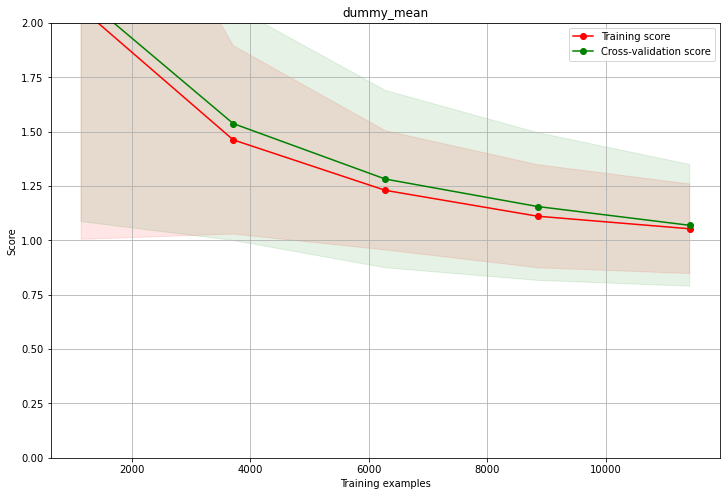

[dummy_median]: 0.6678517039942227 +/-0.06464186349579217


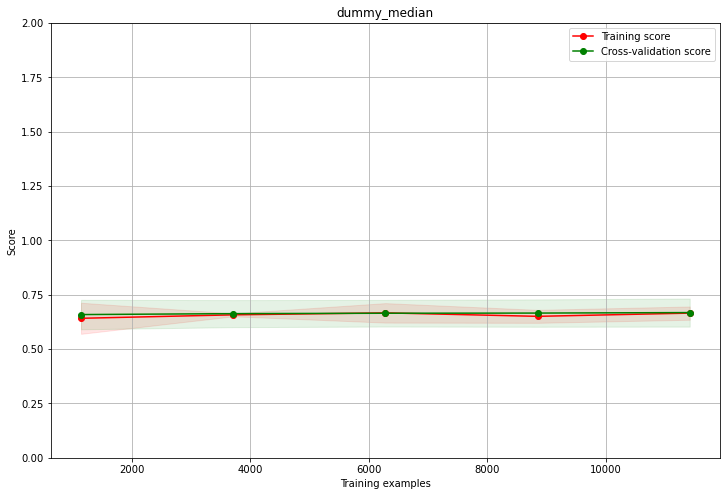

[dt-5md]: 0.47429303392548167 +/-0.07543574968623956


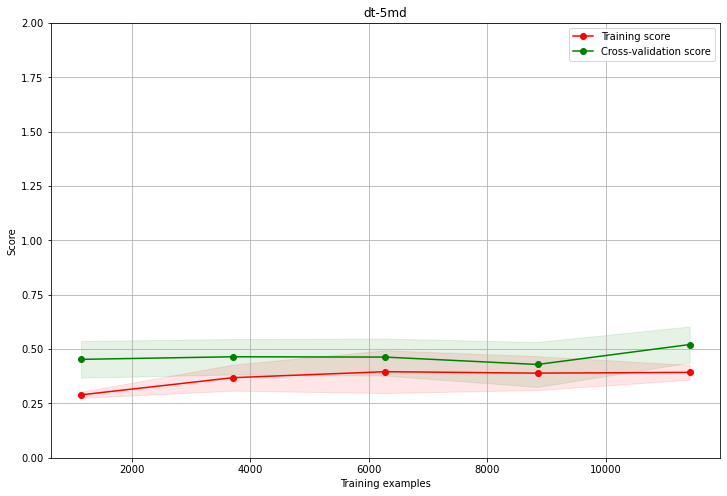

In [34]:
def get_models():
    return [
        ('dummy_mean', DummyRegressor(strategy='mean')),
        ('dummy_median', DummyRegressor(strategy='median')),
        ('dt-5md', DecisionTreeRegressor(max_depth=5)),
    ]

run(train, plot_lc=True)

1. Dodaj `RandomForest`, `ExtraTreesRegressor` do modeli i zobacz wynik.
2. Sprawdź różne wartości parametrów (zwłaszcza dla: `n_estimators`, `max_depth`).
3. Narysuj `learning_curve`.
4. Dla `RF` wynik powinien być lepszy niż dla DT, około **0.41-0.44**.

[RandomForest-5md]: 0.5027569819621124 +/-0.05721459762703185


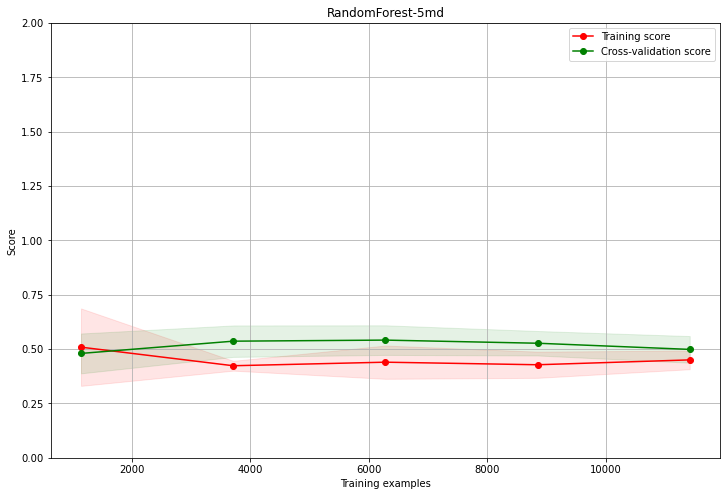

[RandomForest-10md]: 0.47719437430740247 +/-0.06212855783439486


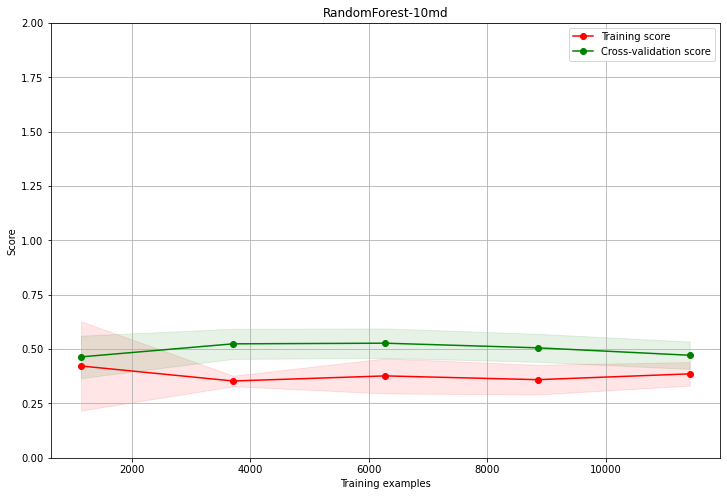

[ExtraTreesRegressor-5md]: 0.8460672023862991 +/-0.2036275135960346


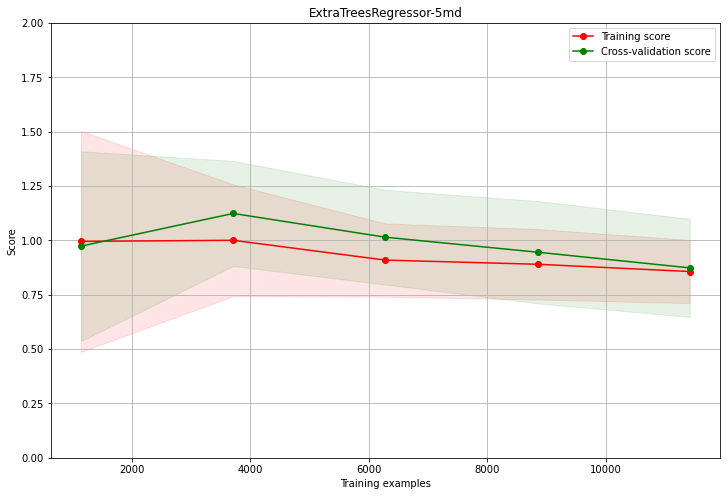

In [38]:
def get_models():
    return [
        ('RandomForest-5md', RandomForestRegressor(max_depth=5, n_estimators=100)),
        ('RandomForest-10md', RandomForestRegressor(max_depth=10, n_estimators=100)),
        ('ExtraTreesRegressor-5md', ExtraTreesRegressor(max_depth=5, n_estimators=100)),
    ]

run(train, plot_lc=True)

# Feature engineering

Popracujmy teraz nad cechami.

Przy okazji zróbmy funkcję, która będzie wyciągać podane [percentyle](https://bit.ly/3a2Xq79), np. 1, 5, 95, 99 i 100.

In [39]:
def summary(values, percentiles=[1, 5, 95, 99, 100]):
    for percentile in percentiles:
        print('{0}th -> {1}'.format(percentile, np.percentile(values, percentile) ))

Zobaczmy przy okazji korelacji (pamiętaj, że ta korelacja może "wyłapać" tylko  liniowe zależności - inne nie potrafi).

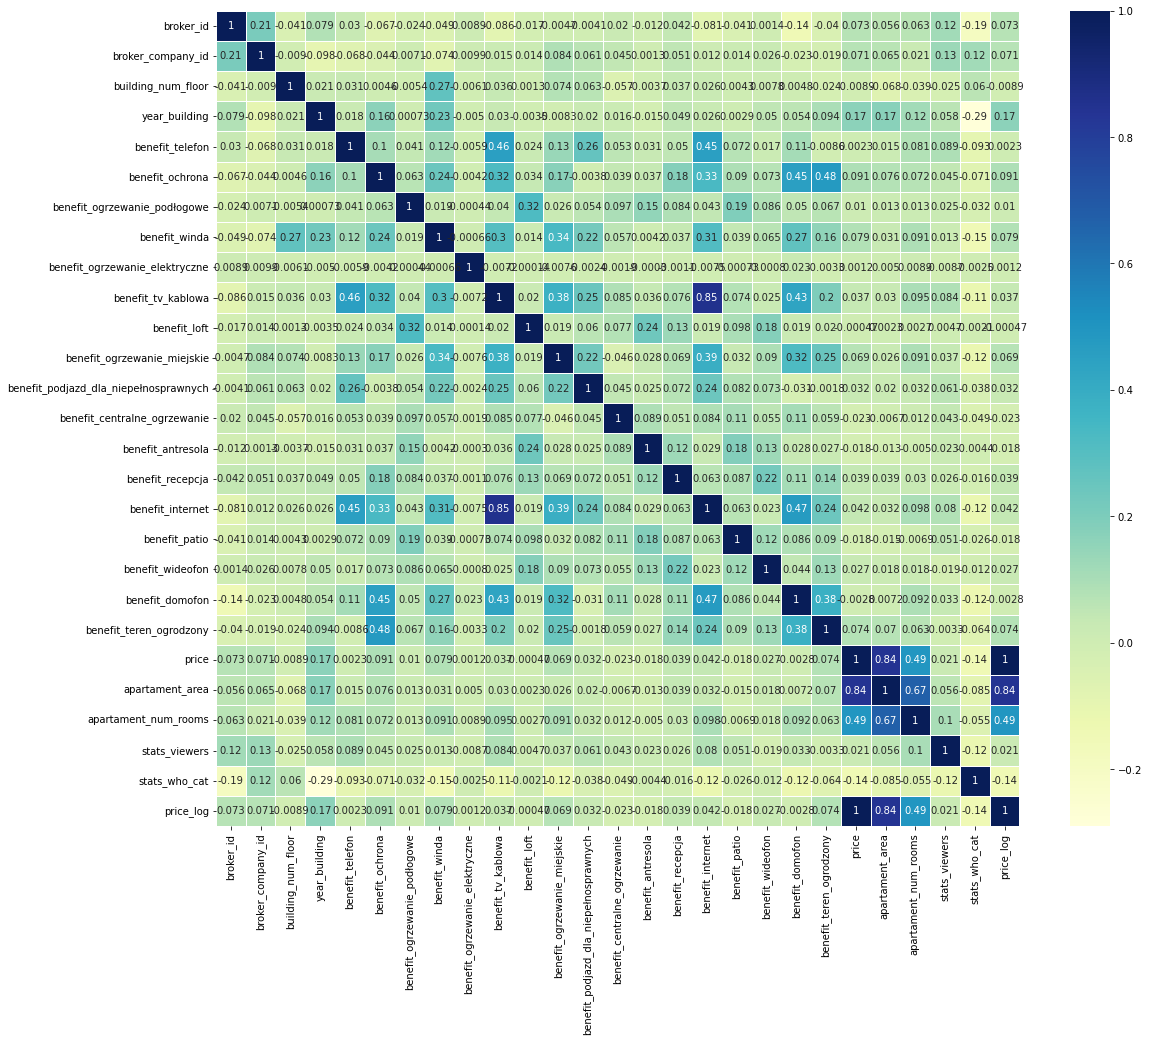

In [40]:
plt.rcParams['figure.figsize']=(18,15)
sns.heatmap(train.corr(method='spearman'), annot=True, linewidths=.8, cmap="YlGnBu");

## Powierzchnia

Jedną z cech, która na pewno jest ważna, jest powierzchnia nieruchomości. Zbadajmy to dokładniej.

1th -> 28.0
5th -> 36.0
95th -> 149.0
99th -> 215.83799999999974
100th -> 1140000.0


<AxesSubplot:>

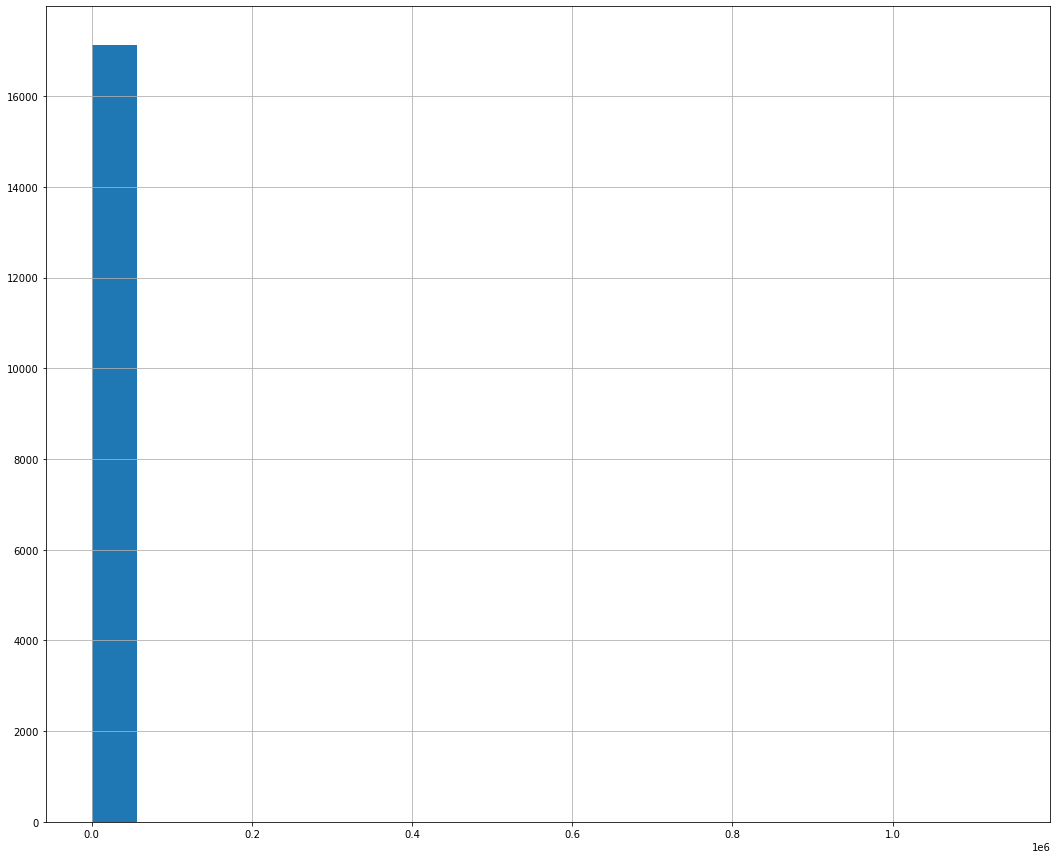

In [41]:
summary(train.apartament_area)
train.apartament_area.hist(bins=20)

Jak widać, są jakieś ekstremalnie duże powierzchnie. Największa **1 140 000** - to coś za dużo. 

Widać, że **99. percentyl** jest **~215.8m2**, co jest w miarę ok... Sprawdźmy, jak dużo jest nieruchomości z powierzchnią większą niż **400m2**.

In [42]:
train[ train.apartament_area > 400 ].apartament_area

0    1140000.00
0        425.00
0        407.90
0        417.11
0        600.00
0        476.00
0        424.00
0        483.37
0     515000.00
Name: apartament_area, dtype: float64

Widać, że mamy dwa ekstremalne przypadki: **1 140 000** i **515 000**. 

Wyrzućmy wszystko co jest ponad 500m2 (dokładnie 3 obiekty). 

Zróbmy również histogram.

1th -> 28.0
5th -> 36.0
95th -> 149.0
99th -> 215.34
100th -> 483.37


<AxesSubplot:>

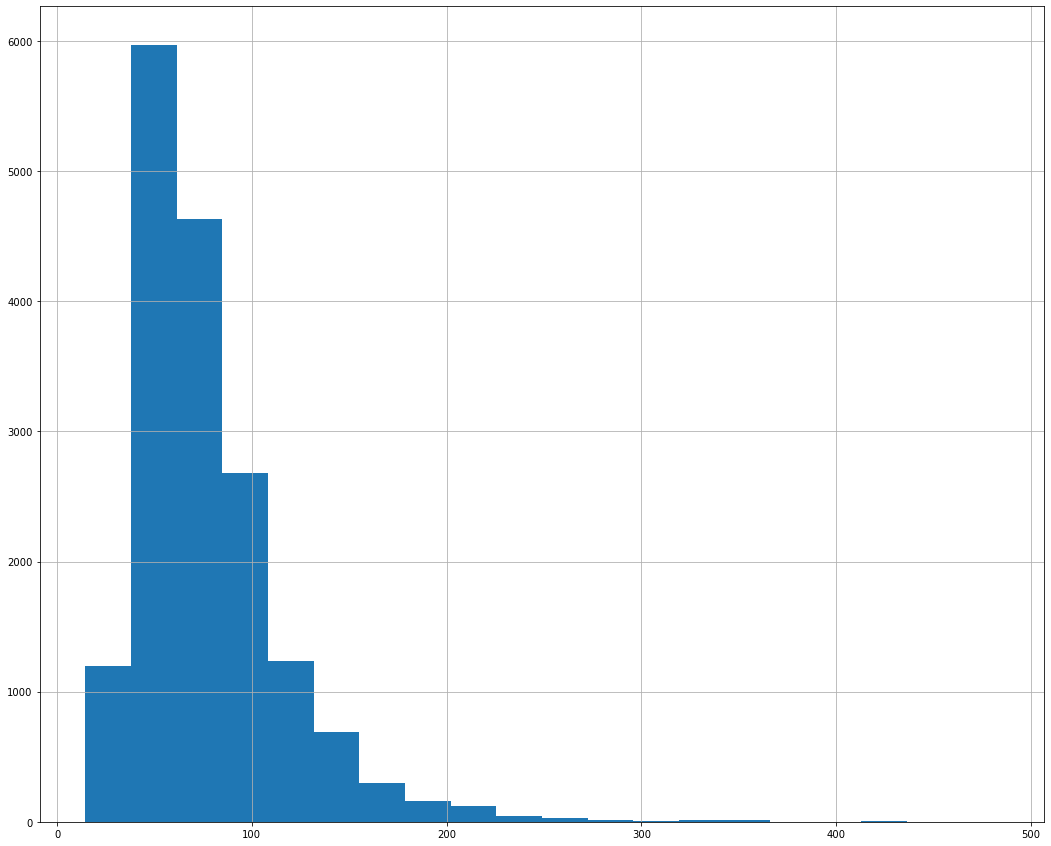

In [43]:
train = train[ train.apartament_area < 500 ]
summary(train.apartament_area)
train.apartament_area.hist(bins=20)

Teraz już zdecydowanie lepiej widać rozkład. Również jest on skrzywiony i, jak już wiesz, chcemy w takiej sytuacji zrobić logarytm.

/var/folders/00/3f1t2rhd45l6fvmbkz20ptgh00dr78/T/ipykernel_10767/1831724594.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['apartament_area_log'] = np.log( train.apartament_area )


<AxesSubplot:>

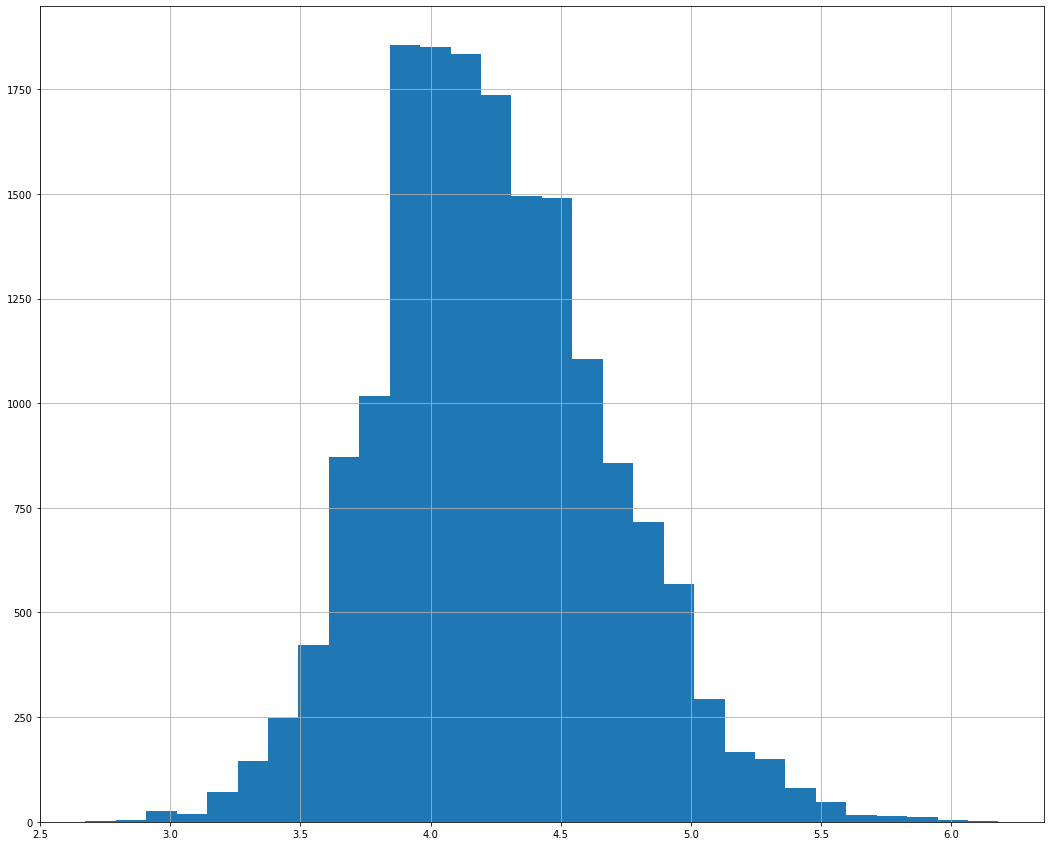

In [44]:
train['apartament_area_log'] = np.log( train.apartament_area )
train['apartament_area_log'].hist(bins=30)

Bardzo ładnie! Widać, że rozkład jest symetryczny, ale sprawdźmy, czy to daje lepszy wynik. Przy okazji najpierw sprawdźmy, czy funkcja `get_feats()` "wychwyciła" nową zmienną.

In [45]:
get_feats(train)

array(['building_num_floor', 'year_building', 'benefit_telefon',
       'benefit_ochrona', 'benefit_ogrzewanie_podłogowe', 'benefit_winda',
       'benefit_ogrzewanie_elektryczne', 'benefit_tv_kablowa',
       'benefit_loft', 'benefit_ogrzewanie_miejskie',
       'benefit_podjazd_dla_niepełnosprawnych',
       'benefit_centralne_ogrzewanie', 'benefit_antresola',
       'benefit_recepcja', 'benefit_internet', 'benefit_patio',
       'benefit_wideofon', 'benefit_domofon', 'benefit_teren_ogrodzony',
       'apartament_area', 'apartament_num_rooms', 'stats_viewers',
       'stats_who_cat', 'apartament_area_log'], dtype=object)

Na końcu listy widać `apartament_area_log`, a więc działa dobrze :). 

1. Uruchom kilka modeli i zobacz, jak wpłynęła nowa cecha `apartament_area_log`.
2. Może się okazać, że wcale się nie polepszyło, to jest też OK.
3. Jeśli zdecydujesz się usunąć nową cechę, to wystarczy wpisać `del train['apartament_area_log']`, ale jest szansa, że jeszcze może się ona przydać.

[RandomForest-5md]: 0.49554956224687796 +/-0.05991349522489762


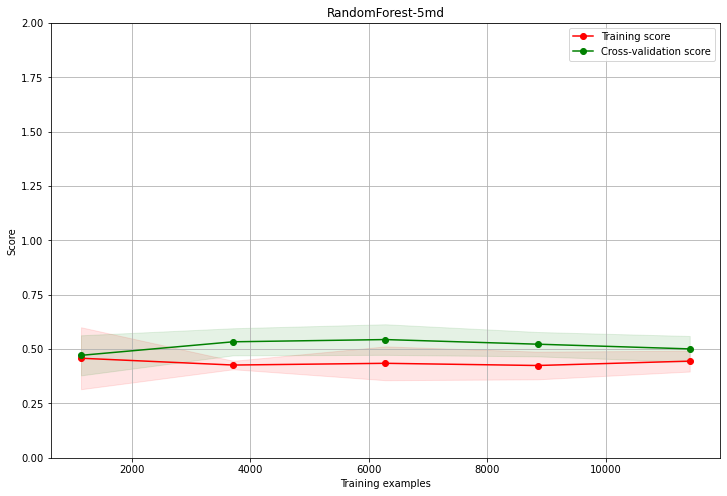

[RandomForest-10md]: 0.4649275197587685 +/-0.062083621378593475


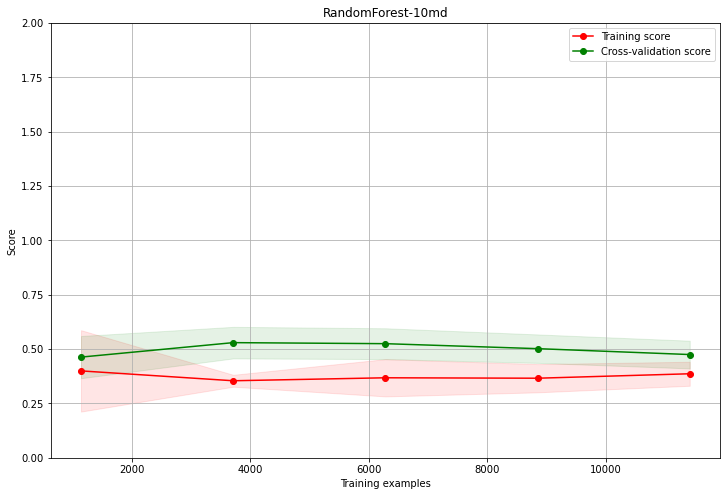

[ExtraTreesRegressor-5md]: 0.6748280556421323 +/-0.05833454898437688


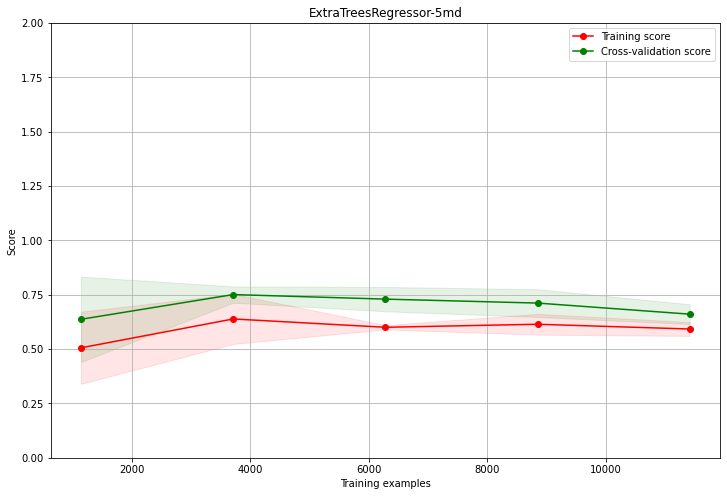

In [46]:
def get_models():
    return [
        ('RandomForest-5md', RandomForestRegressor(max_depth=5, n_estimators=100)),
        ('RandomForest-10md', RandomForestRegressor(max_depth=10, n_estimators=100)),
        ('ExtraTreesRegressor-5md', ExtraTreesRegressor(max_depth=5, n_estimators=100)),
    ]

run(train, plot_lc=True)

## Liczba pięter budynku

 4     3797
 3     3034
 5     1646
 6     1413
 10    1299
 2     1218
 7     1010
 8      900
-1      597
 12     460
 9      352
 11     320
 15     246
 1      198
 13     149
 16     113
 17     107
 14     100
 30      67
 22      27
 20      21
 18      13
 19       9
 25       9
 21       7
 23       6
 28       4
 24       3
Name: building_num_floor, dtype: int64


<AxesSubplot:>

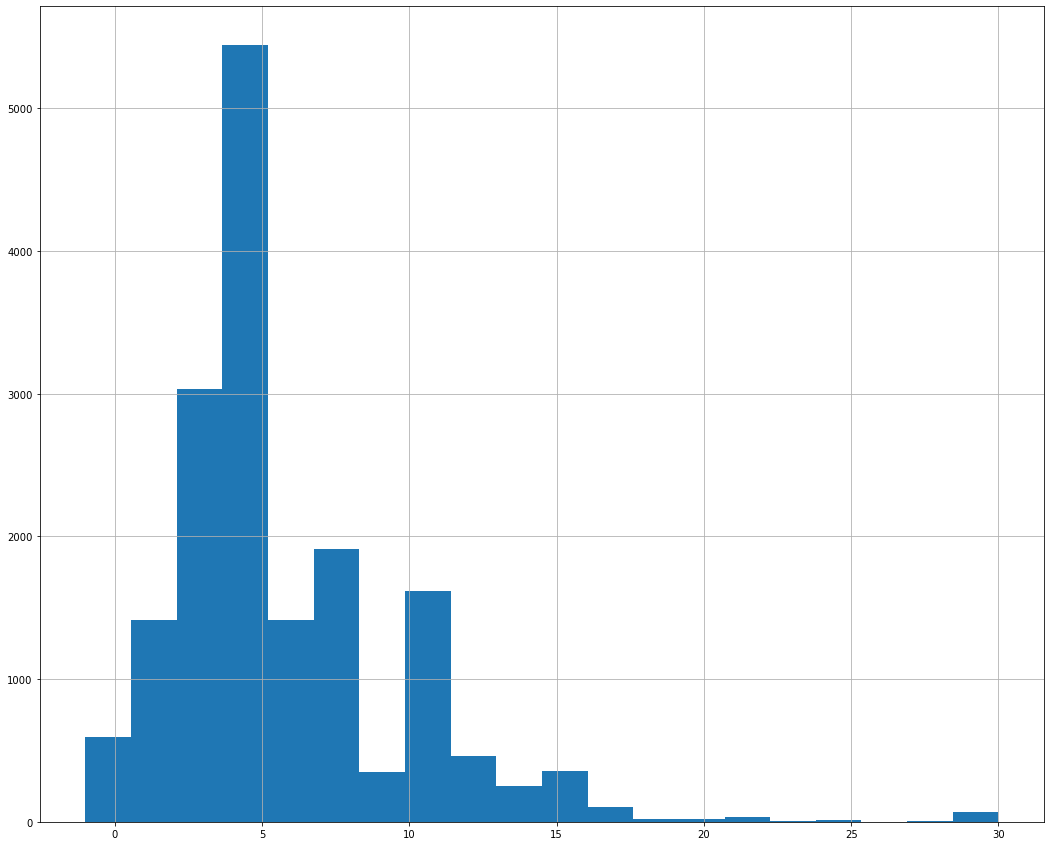

In [47]:
print( train.building_num_floor.value_counts() )
train['building_num_floor'].hist(bins=20)

/var/folders/00/3f1t2rhd45l6fvmbkz20ptgh00dr78/T/ipykernel_10767/3658189023.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['building_num_floor_other'] = train.building_num_floor.map(lambda x: 0 if x in other_floor else x)


<AxesSubplot:>

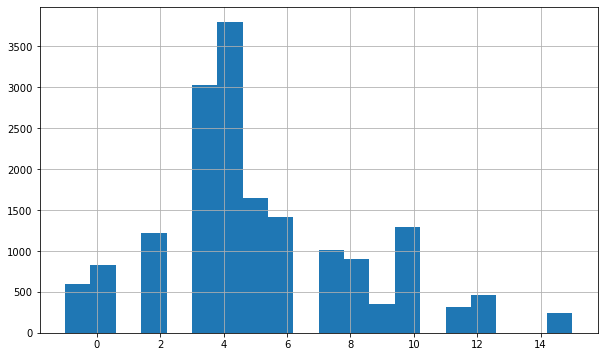

In [48]:
cnt_values = train.building_num_floor.value_counts().reset_index()
other_floor = set(cnt_values[ cnt_values.building_num_floor < 200 ]['index'].values)

train['building_num_floor_other'] = train.building_num_floor.map(lambda x: 0 if x in other_floor else x)
train['building_num_floor_other'].hist(bins=20, figsize=(10, 6))

Teraz możemy zastosować `one_hot_encoding` dla nowej zmiennej `building_num_floor_other`. Do tego użyjemy funkcji z `pandas`: `.get_dummies()`.

In [49]:
df_ohe = pd.get_dummies(train['building_num_floor_other'], prefix='building_num_floor')
df_ohe.head()

,building_num_floor_-1,building_num_floor_0,building_num_floor_2,building_num_floor_3,building_num_floor_4,building_num_floor_5,building_num_floor_6,building_num_floor_7,building_num_floor_8,building_num_floor_9,building_num_floor_10,building_num_floor_11,building_num_floor_12,building_num_floor_15
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


Mając nowy dataframe `df_one`, możemy go połączyć z `train`, ale tego nie polecam, bo potem ciężko jest usunąć nowe kolumny (oczywiście, można je zapisać na boku). Lepiej zrobić nowy zbiór, powiedzmy `train_ext`, na którym będziemy robić eksperymenty. Jak się nie uda, to po prostu usuwamy cały `train_ext` i tyle.

Użyjemy funkcji `.concat()` podając wymiar `axis=1`, co w praktyce oznacza, że chcemy skleić dwa `dataframe`'y. Liczba wierszy zostanie stała, dokładamy tylko nowe kolumny (te, które wygenerowaliśmy za pomocą `one_hot_encoding`).

In [50]:
#sprawdźmy wymiary na początek
print(train.shape)
print(df_ohe.shape)

(17125, 53)
(17125, 14)


In [51]:
#wymiary po sklejeniu
train_ext = pd.concat([train, df_ohe], axis=1)
train_ext.shape

(17125, 67)

Wymiary zgadzają się, teraz popatrzmy na kolejną zmienną. 

## Na którym piętrze jest nieruchomość? 
Tym razem interesuje nas, na którym piętrze znajduje się mieszkanie. Myślę, że warto zrobić dwie osobne zmienne - czy nieruchomość jest na parterze czy na ostatnim piętrze. Zakładając, że to powinno wpłynąć na model.

In [52]:
train['apartament_floor'].value_counts()

1             3254
3             3090
2             3021
parter        2101
4             1801
5             1148
6              631
7              490
8              367
9              294
10             263
-1             231
11             148
12              70
14              59
13              42
15              38
powyżej 30      21
poddasze        20
16              14
17              12
19               4
20               2
21               1
25               1
18               1
26               1
Name: apartament_floor, dtype: int64

Praca ze "stringiem" jest dość trudna, dlatego zmapujmy wszystko do "int", np. parter naturalnie będzie jako 0. Powyżej 30 będzie po prostu 30, bo jak widać jest wolne miejsce, na poddasze można dać większą liczbę, np. 50.

/var/folders/00/3f1t2rhd45l6fvmbkz20ptgh00dr78/T/ipykernel_10767/2082411037.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['apartament_floor'] = train.apartament_floor.map(lambda x: map_floor[x] if x in map_floor else int(x)).astype('int8')


<AxesSubplot:>

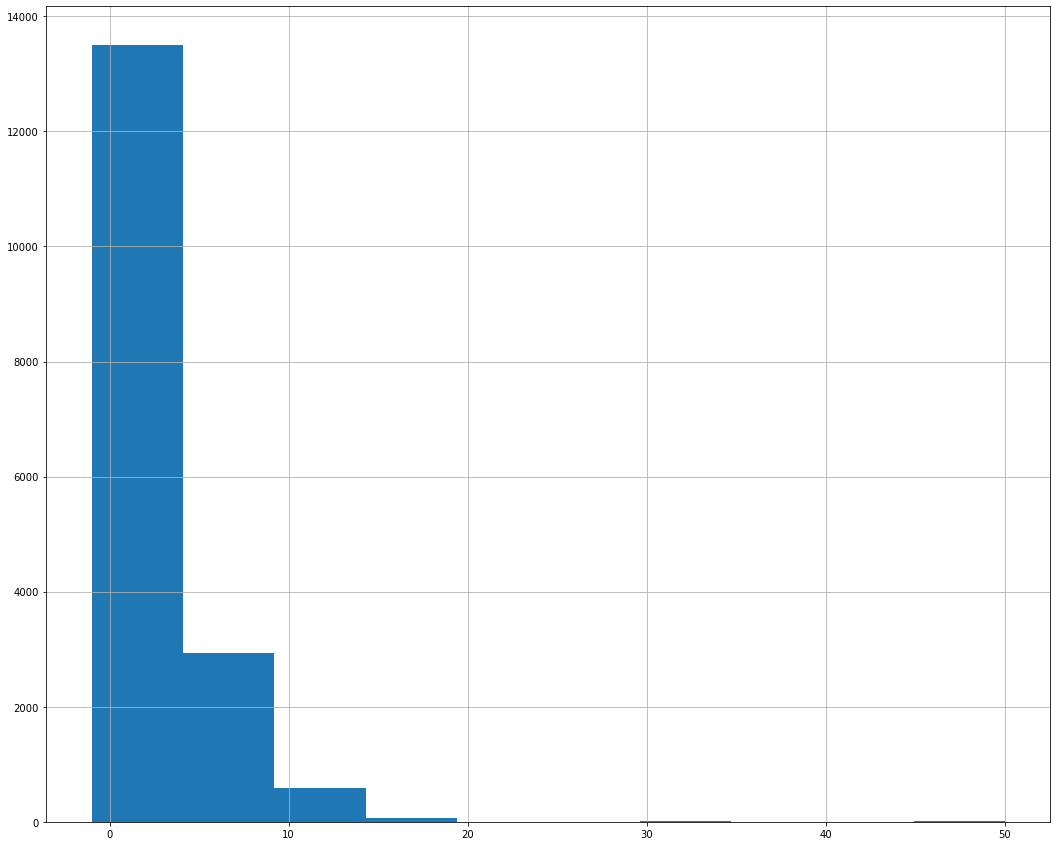

In [53]:
map_floor = {
    'parter': 0,
    'poddasze': 50,
    'powyżej 30': 30
}

train['apartament_floor'] = train.apartament_floor.map(lambda x: map_floor[x] if x in map_floor else int(x)).astype('int8')
train['apartament_floor'].hist()

Sprawdźmy z ciekawości, jak dużo jest mieszkań na ostatnim lub przedostatnim piętrze.

In [54]:
print(train[ train.building_num_floor == train.apartament_floor ].shape)
print(train[ train.building_num_floor == (train.apartament_floor + 1) ].shape)

(3520, 53)
(3372, 53)


In [55]:
train['apartament_last_floor'] = train.building_num_floor == train.apartament_floor
train['apartament_one_before_last_floor'] = train.building_num_floor == (train.apartament_floor + 1)
train['apartament_parter'] = train.apartament_floor == 0

/var/folders/00/3f1t2rhd45l6fvmbkz20ptgh00dr78/T/ipykernel_10767/1549543739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['apartament_last_floor'] = train.building_num_floor == train.apartament_floor
/var/folders/00/3f1t2rhd45l6fvmbkz20ptgh00dr78/T/ipykernel_10767/1549543739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['apartament_one_before_last_floor'] = train.building_num_floor == (train.apartament_floor + 1)
/var/folders/00/3f1t2rhd45l6fvmbkz20ptgh00dr78/T/ipykernel_10767/154954

## Zmienna docelowa + logarytm

Jak pamiętasz, zmienna docelowa `price` jest dość mocno skrzywiona. Dlatego zrobiliśmy wcześniej transformację logarytmiczną.

Teraz pomyślmy w ten sposób:
- Nauczymy model na zmiennej docelowej `log(price)`;
- Model zrobi predykcję również jako `log(price)`;
- Następnie odkręcamy `log(price)` do normalnego `price`, używając `np.exp`.

Tylko trzeba przerobić trochę nasze funkcje do nauczania. Zróbmy to.

[dt-5md]: 0.5294596855945878 +/-0.1313596029853313


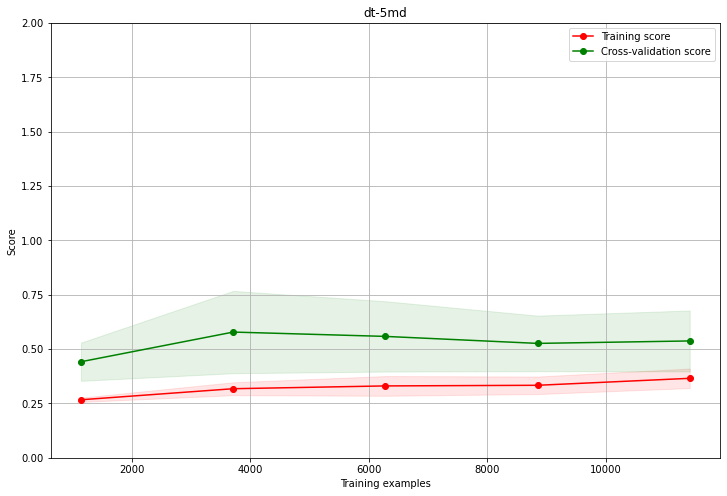

[rf-5md-90est]: 0.4102574927647416 +/-0.09145941307531175


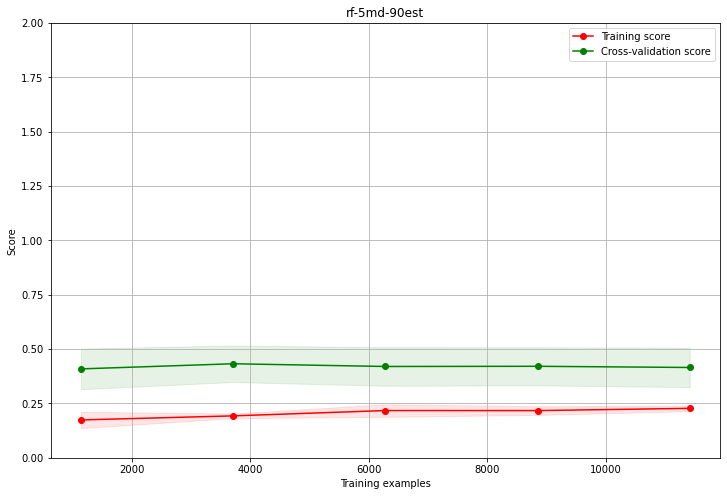

In [56]:
def get_models():
    return [
        ('dt-5md', DecisionTreeRegressor(max_depth=5)),
        ('rf-5md-90est', RandomForestRegressor(max_depth=10, n_estimators=150, max_features=0.8)),
    ]

run(train, plot_lc=True, target_log=True)